In [105]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

In [106]:
cv = pd.read_csv('cv_merged.csv')
cv = cv.drop(columns=['Unnamed: 0'])

In [107]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279451 entries, 0 to 279450
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   store_code_1        279451 non-null  int64  
 1   store_code_2        279451 non-null  int64  
 2   total_cross_visits  279451 non-null  int64  
 3   store_name_1        27605 non-null   object 
 4   gla_1               274996 non-null  float64
 5   gla_category_1      274996 non-null  object 
 6   bl1_label_1         277296 non-null  object 
 7   bl2_label_1         277296 non-null  object 
 8   bl3_label_1         277296 non-null  object 
 9   store_name_2        26969 non-null   object 
 10  gla_2               273744 non-null  float64
 11  gla_category_2      273744 non-null  object 
 12  bl1_label_2         277764 non-null  object 
 13  bl2_label_2         277764 non-null  object 
 14  bl3_label_2         277764 non-null  object 
 15  mall_id             279412 non-nul

# Interaction analysis

In [108]:
cv['bl3_label_1'].unique()


array(["Women's Fashion", 'Family Fashion', 'Monobrand mainstream',
       'Department Stores', 'Hypermarkets', 'Multibrand mainstream',
       'General Culture & Media & Technology', 'Sport clothes & Outdoor',
       'Women underwear', nan, 'Family footwear', 'Supermarkets',
       'Hard discounters', 'Themed gift', 'Multibrand electronics',
       'Pharmacy', "Men's Fashion", 'Sport general store',
       'American & Burgers', 'Decoration accessories / Design',
       'Bookstore & stationery', 'Do It Yourself and others materials',
       'Mobile Phones & Communication & Internet', 'Insurance & Banks',
       'Mixed: small accessories, bags and fancy jewellery',
       'Coffee beans & capsules', 'Monobrand electronics', 'Toys',
       'General home furniture', 'Parapharmacy', 'Women footwear',
       'Gardening', 'Modern Jewellery & Watches',
       'Pet shops & pet supplies', 'Jeans', 'Others Immaterial services',
       'Children fashion', 'Tobbaconists, lotteries and other activit

We conduct category-level interaction analysis to identify synergy and competition effects between tenant types.    

Given the trade-off between interpretability and statistical robustness, we evaluate three category granularities (bl1, bl2, bl3) and select bl2 as the primary level of analysis.

In [23]:
df_out = cv.dropna(
        subset=["bl1_label_1","bl1_label_2", 
                "total_cross_visits", "mall_id"]
    ).copy()

In [ ]:
def pair_sample_stats(df, cat_col_1, cat_col_2, level_name):
    """
    Compute number of store pairs per category pair (within each mall)
    for a given category granularity.
    """
    df_tmp = df.copy()
    
    # create category pair
    df_tmp["cat_pair"] = df_tmp.apply(
        lambda x: tuple(sorted([x[cat_col_1], x[cat_col_2]])),
        axis=1
    )
    
    stats = (
        df_tmp
        .groupby(["mall_id", "cat_pair"])
        .size()
        .rename("n_store_pairs")
        .reset_index()
    )
    
    stats["level"] = level_name
    return stats


In [ ]:
stats_bl1 = pair_sample_stats(
    df_out,
    "bl1_label_1",
    "bl1_label_2",
    "bl1"
)

stats_bl2 = pair_sample_stats(
    df_out,
    "bl2_label_1",
    "bl2_label_2",
    "bl2"
)

stats_bl3 = pair_sample_stats(
    df_out,
    "bl3_label_1",
    "bl3_label_2",
    "bl3"
)

stats_all = pd.concat(
    [stats_bl1, stats_bl2, stats_bl3],
    ignore_index=True
)

In [19]:
stats_all.groupby("level")["n_store_pairs"].describe()

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
bl1,2119.0,130.084002,247.492111,1.0,11.0,39.0,130.0,2278.0
bl2,12522.0,22.013097,39.149298,1.0,4.0,9.0,24.0,741.0
bl3,37918.0,7.269582,15.351617,1.0,2.0,3.0,7.0,666.0


## Prepare data

In [109]:
df = cv.copy()
df

,store_code_1,store_code_2,total_cross_visits,store_name_1,gla_1,gla_category_1,bl1_label_1,bl2_label_1,bl3_label_1,store_name_2,gla_2,gla_category_2,bl1_label_2,bl2_label_2,bl3_label_2,mall_id
0,956,1088969,1433132,NaN,816.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,NaN,1384.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,12.0
1,1302413,1302533,1365018,NaN,3735.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,3303.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,18.0
2,1089051,1090732,1344999,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,1230.60,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
3,1088451,1089051,1283772,NaN,2421.70,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
4,1089051,1093829,1258417,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,2150.60,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279446,1106690,1314101,1,NaN,59.21,SMALL UNITS,Food & Beverage Services,Gourmet Food Products,Regional Gourmet,NaN,85.95,SMALL UNITS,Home,Furniture & Interior Design,General home furniture,32.0
279447,1302370,1303242,1,NaN,105.00,SMALL UNITS,Health & Beauty,Hair & Body,"Beauty salons, UVA and nail salons",NaN,210.00,SMALL UNITS,Health & Beauty,Optician,Optician & Sunglasses,18.0
279448,1095349,1314108,1,NaN,105.00,SMALL UNITS,Fashion apparel,Family Fashion,Jeans,NaN,135.30,SMALL UNITS,Food & Beverage Services,Sweet moments,Patisseries & Bakeries & Donuts,33.0
279449,1083467,1313061,1,NaN,79.23,SMALL UNITS,Health & Beauty,Optician,Optician & Sunglasses,NaN,61.43,SMALL UNITS,Sport,Sport Clothes & Equipment,Sport clothes & Outdoor,24.0


In [ ]:
df[df[['store_code_1', 'store_code_2']].duplicated()]

,store_code_1,store_code_2,total_cross_visits,store_name_1,gla_1,gla_category_1,bl1_label_1,bl2_label_1,bl3_label_1,store_name_2,gla_2,gla_category_2,bl1_label_2,bl2_label_2,bl3_label_2,mall_id
2480,1077572,1079367,184989,NaN,159.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,3064.0,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,36.0
2580,1077572,1095570,180057,NaN,159.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,2620.0,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,36.0
2634,1077572,1313605,178202,NaN,159.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,1127.0,MSU,Fashion apparel,Family Fashion,Family Fashion,36.0
3005,1077572,1079797,164509,NaN,159.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,1571.0,MSU,Fashion apparel,Women's Fashion,Women's Fashion,36.0
3012,1077572,1077602,164259,NaN,159.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,23433.0,LARGE UNITS,Department Stores,Department Stores,Department Stores,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267023,1076288,1078007,24,NaN,NaN,NaN,Fashion apparel,Lingerie & Underwear,Women underwear,NaN,252.0,SMALL UNITS,Services,Car services,Car wash,28.0
271675,1039128,1309595,14,NOCIBE,289.0,SMALL UNITS,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,FREE,101.0,SMALL UNITS,Culture & Media & Technology,Mobile Phones & Communication,Mobile Phones & Communication & Internet,22.0
273761,1039128,1085611,10,NOCIBE,289.0,SMALL UNITS,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,IZAC,183.0,SMALL UNITS,Fashion apparel,Men's Fashion,Men's Fashion,22.0
273908,1039128,1075392,10,NOCIBE,289.0,SMALL UNITS,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,LEVI'S,159.0,SMALL UNITS,Fashion apparel,Family Fashion,Jeans,22.0


In [111]:
df[(df['store_code_1'] == 1077572) & (df['store_code_2'] == 1079797)]

,store_code_1,store_code_2,total_cross_visits,store_name_1,gla_1,gla_category_1,bl1_label_1,bl2_label_1,bl3_label_1,store_name_2,gla_2,gla_category_2,bl1_label_2,bl2_label_2,bl3_label_2,mall_id
3004,1077572,1079797,164509,NaN,322.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,1571.0,MSU,Fashion apparel,Women's Fashion,Women's Fashion,36.0
3005,1077572,1079797,164509,NaN,159.0,SMALL UNITS,Home,Furniture & Interior Design,Decoration accessories / Design,NaN,1571.0,MSU,Fashion apparel,Women's Fashion,Women's Fashion,36.0


In [ ]:
# drop the data with closed contracts (gla is NaN) and block_id not in latest gla file
df = df[(df['gla_1'].isna() == False) & (df['gla_2'].isna() == False)]

<class 'pandas.core.frame.DataFrame'>
Index: 269462 entries, 0 to 279449
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   store_code_1        269462 non-null  int64  
 1   store_code_2        269462 non-null  int64  
 2   total_cross_visits  269462 non-null  int64  
 3   store_name_1        25586 non-null   object 
 4   gla_1               269462 non-null  float64
 5   gla_category_1      269462 non-null  object 
 6   bl1_label_1         269462 non-null  object 
 7   bl2_label_1         269462 non-null  object 
 8   bl3_label_1         269462 non-null  object 
 9   store_name_2        25586 non-null   object 
 10  gla_2               269462 non-null  float64
 11  gla_category_2      269462 non-null  object 
 12  bl1_label_2         269462 non-null  object 
 13  bl2_label_2         269462 non-null  object 
 14  bl3_label_2         269462 non-null  object 
 15  mall_id             269462 non-null  fl

In [122]:
df_blocks = pd.read_csv('df_blocks.csv')
df_fact_stores = pd.read_csv('fact_stores_V1.csv')

## Get total_people_in for each store for normalization

In [129]:
store_visits = (
    df_fact_stores
    .groupby('store_code', as_index=False)
    .agg(total_people_in=('people_in', 'sum'))
)

store_visits

,store_code,total_people_in
0,42,1347231
1,97,59592
2,111,39024
3,116,47106
4,178,289946
...,...,...
3542,1314311,53896
3543,1314312,2949
3544,1314332,3218
3545,1314365,4641


In [132]:
df_merged = df.merge(
    store_visits,
    left_on="store_code_1",
    right_on="store_code",
    how="left"
)

df_merged = df_merged.rename(
    columns={"total_people_in": "total_people_in_1"}
)

df_merged = df_merged.merge(
    store_visits,
    left_on="store_code_2",
    right_on="store_code",
    how="left"
)

df_merged = df_merged.rename(
    columns={"total_people_in": "total_people_in_2"}
)

In [134]:
df_merged.drop(columns=['store_code_x', 'store_code_y'], inplace=True)

df_merged

,store_code_1,store_code_2,total_cross_visits,store_name_1,gla_1,gla_category_1,bl1_label_1,bl2_label_1,bl3_label_1,store_name_2,gla_2,gla_category_2,bl1_label_2,bl2_label_2,bl3_label_2,mall_id,total_people_in_1,total_people_in_2
0,956,1088969,1433132,NaN,816.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,NaN,1384.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,12.0,1377008.0,3767367.0
1,1302413,1302533,1365018,NaN,3735.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,3303.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,18.0,1421671.0,1043469.0
2,1089051,1090732,1344999,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,1230.60,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0,2001822.0,1047589.0
3,1088451,1089051,1283772,NaN,2421.70,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0,972041.0,2001822.0
4,1089051,1093829,1258417,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,2150.60,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0,2001822.0,972503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269457,1033908,1084729,1,NaN,117.00,SMALL UNITS,Health & Beauty,"Perfumery, beautycare",Monobrand mainstream,NaN,883.51,MSU,Fashion apparel,Family Fashion,Family Fashion,26.0,206897.0,205090.0
269458,1106690,1314101,1,NaN,59.21,SMALL UNITS,Food & Beverage Services,Gourmet Food Products,Regional Gourmet,NaN,85.95,SMALL UNITS,Home,Furniture & Interior Design,General home furniture,32.0,97213.0,317.0
269459,1302370,1303242,1,NaN,105.00,SMALL UNITS,Health & Beauty,Hair & Body,"Beauty salons, UVA and nail salons",NaN,210.00,SMALL UNITS,Health & Beauty,Optician,Optician & Sunglasses,18.0,9804.0,8308.0
269460,1095349,1314108,1,NaN,105.00,SMALL UNITS,Fashion apparel,Family Fashion,Jeans,NaN,135.30,SMALL UNITS,Food & Beverage Services,Sweet moments,Patisseries & Bakeries & Donuts,33.0,28076.0,3594.0


In [135]:
df  = df_merged.copy()

## Normalization (gla & people_in)

In [136]:
df['interaction_strength_gla'] = (
    df['total_cross_visits'] /
    np.sqrt(df['gla_1'] * df['gla_2'])
)

df['interaction_strength_people'] = (
    df['total_cross_visits'] /
    np.sqrt(df['total_people_in_1'] * df['total_people_in_2'])
)

In [137]:
df['interaction_strength_gla'].describe()

count    269462.000000
mean         33.247789
std          70.901518
min           0.000738
25%           1.942980
50%           8.952872
75%          33.250020
max        2853.486724
Name: interaction_strength_gla, dtype: float64

In [138]:
df['interaction_strength_people'].describe()

count    269217.000000
mean          0.049432
std           0.083050
min           0.000002
25%           0.005172
50%           0.019438
75%           0.059066
max           3.601197
Name: interaction_strength_people, dtype: float64

In [140]:
df[df['interaction_strength_people'] > 1][['store_code_1', 'store_code_2', 'total_cross_visits', 'total_people_in_1', 'total_people_in_2', 'interaction_strength_people']]

,store_code_1,store_code_2,total_cross_visits,total_people_in_1,total_people_in_2,interaction_strength_people
1,1302413,1302533,1365018,1421671.0,1043469.0,1.120725
6,1302413,1303099,1129769,1421671.0,815368.0,1.049333
8,1089051,1307803,1109495,2001822.0,577324.0,1.032055
9,1302393,1302413,1100875,627777.0,1421671.0,1.165295
10,1302533,1303099,1093317,1043469.0,815368.0,1.185303
...,...,...,...,...,...,...
186443,1083888,1306142,492,5828.0,17.0,1.563079
190068,1306142,1313145,448,17.0,10574.0,1.056657
191916,1306142,1313579,427,17.0,7154.0,1.224416
206648,1306142,1310806,281,17.0,2951.0,1.254577


In [141]:
df['cat_pair'] = df.apply(
    lambda x: ' | '.join(sorted([x['bl2_label_1'], x['bl2_label_2']])),
    axis=1
)

df[['bl2_label_1', 'bl2_label_2', 'cat_pair']].head()

,bl2_label_1,bl2_label_2,cat_pair
0,Women's Fashion,Women's Fashion,Women's Fashion | Women's Fashion
1,Family Fashion,Family Fashion,Family Fashion | Family Fashion
2,Family Fashion,Family Fashion,Family Fashion | Family Fashion
3,Family Fashion,Family Fashion,Family Fashion | Family Fashion
4,Family Fashion,Family Fashion,Family Fashion | Family Fashion


## aggreagate the interaction at level: mall × category_pair

In [143]:
agg = (
    df
    .groupby(['mall_id', 'cat_pair'])
    .agg(
        mean_strength_gla=('interaction_strength_gla', 'mean'),
        median_strength_gla=('interaction_strength_gla', 'median'),
        mean_strength_people=('interaction_strength_people', 'mean'),
        median_strength_people=('interaction_strength_people', 'median'),
        n_store_pairs=('interaction_strength_gla', 'count')
    )
    .reset_index()
)

In [144]:
agg

,mall_id,cat_pair,mean_strength_gla,median_strength_gla,mean_strength_people,median_strength_people,n_store_pairs
0,7.0,Accessories | Accessories,50.202730,15.958421,0.033610,0.011956,10
1,7.0,"Accessories | Bars, Coffee and Tea breaks",6.020065,5.311899,0.004019,0.004308,4
2,7.0,Accessories | Computer Products & Electronics ...,43.254401,55.137404,0.025276,0.030869,5
3,7.0,Accessories | Department Stores,14.681596,10.773256,0.040508,0.036584,5
4,7.0,Accessories | Electronics and household applia...,13.707696,2.799818,0.014987,0.003013,20
...,...,...,...,...,...,...,...
12320,36.0,"Tobbaconists, lotteries and other activities |...",31.023360,33.038065,0.013315,0.009975,3
12321,36.0,"Tobbaconists, lotteries and other activities |...",137.073536,104.911097,0.068795,0.052849,3
12322,36.0,"Tobbaconists, lotteries and other activities |...",56.832452,36.363403,0.055810,0.038985,30
12323,36.0,Toys | Women's Fashion,200.040226,95.637214,0.166632,0.130723,10


In [146]:
MIN_PAIRS = 5

agg = agg[agg['n_store_pairs'] >= MIN_PAIRS]

## interaction lift（each mall）

In [149]:
df

,store_code_1,store_code_2,total_cross_visits,store_name_1,gla_1,gla_category_1,bl1_label_1,bl2_label_1,bl3_label_1,store_name_2,...,gla_category_2,bl1_label_2,bl2_label_2,bl3_label_2,mall_id,total_people_in_1,total_people_in_2,interaction_strength_gla,interaction_strength_people,cat_pair
0,956,1088969,1433132,NaN,816.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,NaN,...,MSU,Fashion apparel,Women's Fashion,Women's Fashion,12.0,1377008.0,3767367.0,1348.568679,0.629215,Women's Fashion | Women's Fashion
1,1302413,1302533,1365018,NaN,3735.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,...,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,18.0,1421671.0,1043469.0,388.632207,1.120725,Family Fashion | Family Fashion
2,1089051,1090732,1344999,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,...,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0,2001822.0,1047589.0,768.204138,0.928782,Family Fashion | Family Fashion
3,1088451,1089051,1283772,NaN,2421.70,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,...,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0,972041.0,2001822.0,522.685996,0.920307,Family Fashion | Family Fashion
4,1089051,1093829,1258417,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,...,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0,2001822.0,972503.0,543.698196,0.901917,Family Fashion | Family Fashion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269457,1033908,1084729,1,NaN,117.00,SMALL UNITS,Health & Beauty,"Perfumery, beautycare",Monobrand mainstream,NaN,...,MSU,Fashion apparel,Family Fashion,Family Fashion,26.0,206897.0,205090.0,0.003110,0.000005,"Family Fashion | Perfumery, beautycare"
269458,1106690,1314101,1,NaN,59.21,SMALL UNITS,Food & Beverage Services,Gourmet Food Products,Regional Gourmet,NaN,...,SMALL UNITS,Home,Furniture & Interior Design,General home furniture,32.0,97213.0,317.0,0.014018,0.000180,Furniture & Interior Design | Gourmet Food Pro...
269459,1302370,1303242,1,NaN,105.00,SMALL UNITS,Health & Beauty,Hair & Body,"Beauty salons, UVA and nail salons",NaN,...,SMALL UNITS,Health & Beauty,Optician,Optician & Sunglasses,18.0,9804.0,8308.0,0.006734,0.000111,Hair & Body | Optician
269460,1095349,1314108,1,NaN,105.00,SMALL UNITS,Fashion apparel,Family Fashion,Jeans,NaN,...,SMALL UNITS,Food & Beverage Services,Sweet moments,Patisseries & Bakeries & Donuts,33.0,28076.0,3594.0,0.008390,0.000100,Family Fashion | Sweet moments


In [ ]:
mall_baseline = (
    df
    .groupby('mall_id')
    .agg(
        mall_avg_strength_people=('interaction_strength_people', 'mean'),
        mall_median_strength_people=('interaction_strength_people', 'median'),
        mall_avg_strength_gla=('interaction_strength_gla', 'mean'),
        mall_median_strength_gla=('interaction_strength_gla', 'median')
    )
    .reset_index()
)

In [151]:
agg = agg.merge(mall_baseline, on='mall_id', how='left')

In [152]:
agg

,mall_id,cat_pair,mean_strength_gla,median_strength_gla,mean_strength_people,median_strength_people,n_store_pairs,mall_avg_strength_people,mall_median_strength_people,mall_avg_strength_gla,mall_median_strength_gla
0,7.0,Accessories | Accessories,50.202730,15.958421,0.033610,0.011956,10,0.016860,0.006256,11.848428,3.079272
1,7.0,Accessories | Computer Products & Electronics ...,43.254401,55.137404,0.025276,0.030869,5,0.016860,0.006256,11.848428,3.079272
2,7.0,Accessories | Department Stores,14.681596,10.773256,0.040508,0.036584,5,0.016860,0.006256,11.848428,3.079272
3,7.0,Accessories | Electronics and household applia...,13.707696,2.799818,0.014987,0.003013,20,0.016860,0.006256,11.848428,3.079272
4,7.0,Accessories | Entertainment,4.126280,0.319897,0.005773,0.001217,20,0.016860,0.006256,11.848428,3.079272
...,...,...,...,...,...,...,...,...,...,...,...
8427,36.0,Sweet moments | Toys,136.668266,103.612425,0.063204,0.054333,9,0.061815,0.034547,44.359307,18.232146
8428,36.0,Sweet moments | Women's Fashion,51.705318,19.652044,0.045929,0.029640,86,0.061815,0.034547,44.359307,18.232146
8429,36.0,"Tobbaconists, lotteries and other activities |...",56.832452,36.363403,0.055810,0.038985,30,0.061815,0.034547,44.359307,18.232146
8430,36.0,Toys | Women's Fashion,200.040226,95.637214,0.166632,0.130723,10,0.061815,0.034547,44.359307,18.232146


In [155]:
agg['interaction_lift_gla_mean'] = (
    agg['mean_strength_gla'] / agg['mall_avg_strength_gla']
)

agg['interaction_lift_gla_median'] = (
    agg['median_strength_gla'] / agg['mall_median_strength_gla']
)

agg['interaction_lift_people_mean'] = (
    agg['mean_strength_people'] / agg['mall_avg_strength_people']
)

agg['interaction_lift_people_median'] = (
    agg['median_strength_people'] / agg['mall_median_strength_people']
)

agg.describe()

,mall_id,mean_strength_gla,median_strength_gla,mean_strength_people,median_strength_people,n_store_pairs,mall_avg_strength_people,mall_median_strength_people,mall_avg_strength_gla,mall_median_strength_gla,interaction_lift_gla_mean,interaction_lift_gla_median,interaction_lift_people_mean,interaction_lift_people_median
count,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000,8432.000000
mean,20.759725,33.482328,21.277329,0.045081,0.034844,30.831475,0.050139,0.024904,35.029635,12.091921,0.974925,2.069740,0.914122,1.505525
std,8.105367,43.553252,32.927311,0.054928,0.051133,43.739215,0.026773,0.017907,21.648448,11.190706,1.087182,3.277973,0.805590,1.710320
min,7.000000,0.053235,0.026017,0.000288,0.000051,5.000000,0.014259,0.005450,11.848428,3.079272,0.001483,0.002830,0.006101,0.005663
25%,14.000000,7.530742,3.409455,0.014137,0.008031,8.000000,0.032660,0.009627,18.659442,4.557332,0.272897,0.414747,0.367997,0.469006
50%,19.000000,19.350072,9.893522,0.029245,0.019195,16.000000,0.047136,0.021571,35.897582,9.072779,0.654183,1.087259,0.718412,1.011557
75%,28.000000,42.612813,25.393884,0.058743,0.043858,35.000000,0.067285,0.036944,44.359307,16.841252,1.307684,2.405279,1.231496,1.938877
max,36.000000,667.552182,506.388440,1.419360,1.414065,741.000000,0.119037,0.082884,124.738332,58.289188,18.642283,71.891657,17.850343,50.593071


In [157]:
agg.head()

,mall_id,cat_pair,mean_strength_gla,median_strength_gla,mean_strength_people,median_strength_people,n_store_pairs,mall_avg_strength_people,mall_median_strength_people,mall_avg_strength_gla,mall_median_strength_gla,interaction_lift_gla_mean,interaction_lift_gla_median,interaction_lift_people_mean,interaction_lift_people_median
0,7.0,Accessories | Accessories,50.202730,15.958421,0.033610,0.011956,10,0.01686,0.006256,11.848428,3.079272,4.237079,5.182530,1.993408,1.911247
1,7.0,Accessories | Computer Products & Electronics ...,43.254401,55.137404,0.025276,0.030869,5,0.01686,0.006256,11.848428,3.079272,3.650645,17.905985,1.499127,4.934546
2,7.0,Accessories | Department Stores,14.681596,10.773256,0.040508,0.036584,5,0.01686,0.006256,11.848428,3.079272,1.239118,3.498637,2.402535,5.848132
3,7.0,Accessories | Electronics and household applia...,13.707696,2.799818,0.014987,0.003013,20,0.01686,0.006256,11.848428,3.079272,1.156921,0.909246,0.888886,0.481669
4,7.0,Accessories | Entertainment,4.126280,0.319897,0.005773,0.001217,20,0.01686,0.006256,11.848428,3.079272,0.348255,0.103887,0.342405,0.194560


heavy-tailed
→ Interaction types are defined using mall-normalized lift percentiles to account for the heavy-tailed distribution of cross-visitation patterns:    

Strong Synergy：top 20%        
Neutral：middle 60%       
Weak / Competitive：bottom 20%

## Define Interaction type: synergistic

In [158]:
lift_cols = [
    'interaction_lift_gla_mean',
    'interaction_lift_gla_median',
    'interaction_lift_people_mean',
    'interaction_lift_people_median'
]

q80 = agg[lift_cols].quantile(0.8)
q80


interaction_lift_gla_mean         1.507869
interaction_lift_gla_median       2.911542
interaction_lift_people_mean      1.392249
interaction_lift_people_median    2.259413
Name: 0.8, dtype: float64

In [159]:
for col in lift_cols:
    agg[f'{col}_top20'] = agg[col] >= q80[col]

agg['n_top20_lifts'] = agg[[f'{c}_top20' for c in lift_cols]].sum(axis=1)

In [161]:
agg['is_robust_synergy'] = (
    (agg['n_top20_lifts'] >= 2) &
    (
        agg['interaction_lift_gla_median_top20'] |
        agg['interaction_lift_people_median_top20']
    )
)


In [163]:
agg['is_robust_synergy'].value_counts()

is_robust_synergy
False    6563
True     1869
Name: count, dtype: int64

A category pair is considered synergistic only if it consistently ranks in the top 20% under multiple interaction-lift definitions, including at least one median-based metric.

## Which cat_pair tends to be highly_synergy

In [169]:
pair_stability = (
    agg
    .groupby("cat_pair")
    .agg(
        n_malls=("mall_id", "nunique"),
        n_strong_malls=("is_robust_synergy", "sum")
    )
    .reset_index()
)  

pair_stability["strong_ratio"] = (
    pair_stability["n_strong_malls"] / pair_stability["n_malls"]
)

In [ ]:
# create mall coverage groups
# we prefer the synergy pairs that are stable across many malls
pair_stability["mall_coverage_group"] = pd.cut(
    pair_stability["n_malls"],
    bins=[0, 3, 5, 10, 20, 100],
    labels=["≤3", "4–5", "6–10", "11–20", "20+"]
)

In [172]:
pair_stability.query("n_malls >= 10") \
    .sort_values("strong_ratio", ascending=False) \
    .head(20)

,cat_pair,n_malls,n_strong_malls,strong_ratio,mall_coverage_group
364,Family Fashion | Footwear,19,17,0.894737,11–20
459,Footwear | Footwear,18,16,0.888889,11–20
361,Family Fashion | Family Fashion,20,17,0.850000,11–20
401,Family Fashion | Women's Fashion,20,17,0.850000,11–20
1008,Women's Fashion | Women's Fashion,18,15,0.833333,11–20
474,Footwear | Matern./Childr. Fash.,17,14,0.823529,11–20
395,Family Fashion | Sport Clothes & Equipment,20,16,0.800000,11–20
496,Footwear | Women's Fashion,19,15,0.789474,11–20
493,Footwear | Themed Gift,13,10,0.769231,11–20
377,Family Fashion | Lingerie & Underwear,20,15,0.750000,11–20


In [179]:
pair_stability.sort_values("strong_ratio", ascending=False,inplace=True)
pair_stability.head(50)

# we found different patterns of mall coverage groups:
# accessories and department stores show really high synergy, but this case was derived from only 4 malls
# however,the fashion stores show high synergy with high-mall-coverage, indicating a more robust pattern

,cat_pair,n_malls,n_strong_malls,strong_ratio,mall_coverage_group
7,Accessories | Department Stores,4,4,1.0,4–5
12,Accessories | Florists,1,1,1.0,≤3
274,Department Stores | Other Non-Retail,1,1,1.0,≤3
279,Department Stores | Toys,1,1,1.0,≤3
258,Department Stores | Electronics and household ...,1,1,1.0,≤3
956,Pets | Sweet moments,1,1,1.0,≤3
957,Pets | Toys,1,1,1.0,≤3
961,Pharmacy | Supermarkets,2,2,1.0,≤3
964,"Pharmacy | Tobbaconists, lotteries and other a...",2,2,1.0,≤3
264,Department Stores | Grocery,1,1,1.0,≤3


In [ ]:
qua1 = pair_stability[(pair_stability['strong_ratio'] > 0.4) & (pair_stability['n_malls'] >=10)]
qua2 = pair_stability[(pair_stability['strong_ratio'] > 0.4) & (pair_stability['n_malls'] <=5)]
qua3 = pair_stability[(pair_stability['strong_ratio'] < 0.1) & (pair_stability['n_malls'] <=5)]
qua4 = pair_stability[(pair_stability['strong_ratio'] < 0.1) & (pair_stability['n_malls'] >=10)]

In [ ]:
pair_stability.to_csv('pair_new.csv', index=False)  

qua1.to_csv('qua1.csv', index=False)
qua2.to_csv('qua2.csv', index=False)
qua3.to_csv('qua3.csv', index=False)
qua4.to_csv('qua4.csv', index=False)

## Bl2 marginal Effect

In [94]:
agg_test = agg.copy()

agg_test["bl2_A"] = agg_test["cat_pair"].apply(lambda x: x.split("|")[0].strip())
agg_test["bl2_B"] = agg_test["cat_pair"].apply(lambda x: x.split("|")[1].strip())

In [95]:
agg_test

,mall_id,cat_pair,mean_strength,median_strength,n_store_pairs,mall_avg_strength,interaction_lift,interaction_type,is_strong_synergy,bl2_A,bl2_B
0,7.0,Accessories | Accessories,50.202730,15.958421,10,11.523768,4.356451,Strong Synergy,True,Accessories,Accessories
1,7.0,Accessories | Computer Products & Electronics ...,43.254401,55.137404,5,11.523768,3.753494,Strong Synergy,True,Accessories,Computer Products & Electronics games
2,7.0,Accessories | Department Stores,14.681596,10.773256,5,11.523768,1.274027,Neutral,False,Accessories,Department Stores
3,7.0,Accessories | Electronics and household applia...,13.707696,2.799818,20,11.523768,1.189515,Neutral,False,Accessories,Electronics and household appliances
4,7.0,Accessories | Entertainment,4.126280,0.319897,20,11.523768,0.358067,Neutral,False,Accessories,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...
8427,36.0,Sweet moments | Toys,136.668266,103.612425,9,39.386420,3.469934,Strong Synergy,True,Sweet moments,Toys
8428,36.0,Sweet moments | Women's Fashion,51.705318,19.652044,86,39.386420,1.312770,Neutral,False,Sweet moments,Women's Fashion
8429,36.0,"Tobbaconists, lotteries and other activities |...",56.832452,36.363403,30,39.386420,1.442945,Neutral,False,"Tobbaconists, lotteries and other activities",Women's Fashion
8430,36.0,Toys | Women's Fashion,200.040226,95.637214,10,39.386420,5.078914,Strong Synergy,True,Toys,Women's Fashion


In [96]:
long_A = agg_test[["mall_id", "bl2_A", "interaction_lift"]]\
            .rename(columns={"bl2_A": "bl2"})

long_B = agg_test[["mall_id", "bl2_B", "interaction_lift"]]\
            .rename(columns={"bl2_B": "bl2"})

bl2_long = pd.concat([long_A, long_B], ignore_index=True)


In [98]:
bl2_long.head()


,mall_id,bl2,interaction_lift
0,7.0,Accessories,4.356451
1,7.0,Accessories,3.753494
2,7.0,Accessories,1.274027
3,7.0,Accessories,1.189515
4,7.0,Accessories,0.358067


In [99]:
bl2_marginal = (
    bl2_long
    .groupby("bl2")
    .agg(
        n_obs=("interaction_lift", "size"),
        median_lift=("interaction_lift", "median"),
        p75_lift=("interaction_lift", lambda x: x.quantile(0.75)),
        p90_lift=("interaction_lift", lambda x: x.quantile(0.90)),
        mean_lift=("interaction_lift", "mean")
    )
    .reset_index()
)

bl2_marginal = bl2_marginal[bl2_marginal["n_obs"] >= 30]

In [ ]:
bl2_marginal_sorted = bl2_marginal.sort_values(
    ["median_lift", "p75_lift"],
    ascending=False
)

bl2_marginal_sorted

,bl2,n_obs,median_lift,p75_lift,p90_lift,mean_lift
40,Parapharmacy,38,1.735046,2.344331,2.724265,1.740309
0,Accessories,489,1.463160,2.480473,3.807046,1.857337
50,"Tobbaconists, lotteries and other activities",287,1.391309,2.648954,4.133522,1.912593
49,Themed Gift,315,1.338812,2.045995,2.854956,1.556423
43,Pharmacy,237,1.311359,2.428853,3.360083,1.636425
51,Toys,378,1.304770,2.136016,3.711247,1.766076
15,Footwear,645,1.290425,2.175909,3.239052,1.603131
41,"Perfumery, beautycare",698,1.189742,1.876304,2.803732,1.420785
12,Family Fashion,713,1.082377,1.716047,2.475711,1.295312
46,Sport Clothes & Equipment,685,1.061332,1.827891,2.848508,1.395330


In [101]:
bl2_marginal_sorted

,bl2,n_obs,median_lift,p75_lift,p90_lift,mean_lift
40,Parapharmacy,38,1.735046,2.344331,2.724265,1.740309
0,Accessories,489,1.463160,2.480473,3.807046,1.857337
50,"Tobbaconists, lotteries and other activities",287,1.391309,2.648954,4.133522,1.912593
49,Themed Gift,315,1.338812,2.045995,2.854956,1.556423
43,Pharmacy,237,1.311359,2.428853,3.360083,1.636425
51,Toys,378,1.304770,2.136016,3.711247,1.766076
15,Footwear,645,1.290425,2.175909,3.239052,1.603131
41,"Perfumery, beautycare",698,1.189742,1.876304,2.803732,1.420785
12,Family Fashion,713,1.082377,1.716047,2.475711,1.295312
46,Sport Clothes & Equipment,685,1.061332,1.827891,2.848508,1.395330


## AI NLP Interpretation

The interaction_lift captures behavioral synergy very well, but it can only identify weak or absent interaction patterns. It does not allow for a strict identification of economic cannibalization effects.    
可以说明 行为隔离 而非竞争

The interaction_lift distribution is clearly right-skewed rather than symmetric around 1, indicating systematic positive interaction rather than random co-visitation.

In [103]:
df_blocks

,Unnamed: 0,mall_id,block_id,block_type,store_code,store_name,retailer_code,bl1_label,bl2_label,bl3_label,gla,gla_category
0,486,7,1,CELL,1311572,STARBUCKS COFFEE,8636,Food & Beverage Services,"Bars, Coffee and Tea breaks",Seated Cafes & Kiosks,63.0,SMALL UNITS
1,2666,7,2,CELL,1881,GRIMSBY,3538,Fashion apparel,Men's Fashion,Men's Fashion,140.0,SMALL UNITS
2,1610,7,3,CELL,1093449,GEOX,530,Bags & Footwear & Accessories,Footwear,Family footwear,159.0,SMALL UNITS
3,3160,7,4,CELL,1084993,LA BOUTIQUE DU COIFFEUR,27721,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,95.0,SMALL UNITS
4,759,7,5,CELL,1312975,PULL&BEAR,257,Fashion apparel,Family Fashion,Family Fashion,941.0,MSU
...,...,...,...,...,...,...,...,...,...,...,...,...
3849,1308,30,17949,KIOSK,1314827,NaN,124032,Food & Beverage Services,Fast Meal,American & Burgers,NaN,NaN
3850,1493,22,17950,CELL,1314123,CRÊPE TOUCH,100138,Food & Beverage Services,Fast Meal,"Crepes, Waffles & Bretzels",250.0,SMALL UNITS
3851,1167,22,17951,CELL,1313287,POPEYES LOUISIANA KITCHEN,125774,Food & Beverage Services,Fast Meal,American & Burgers,586.0,MSU
3852,4075,14,17953,CELL,1313171,NaN,506,Fashion apparel,Women's Fashion,Women's Fashion,222.9,SMALL UNITS


In [102]:
agg

,mall_id,cat_pair,mean_strength,median_strength,n_store_pairs,mall_avg_strength,interaction_lift,interaction_type,is_strong_synergy
0,7.0,Accessories | Accessories,50.202730,15.958421,10,11.523768,4.356451,Strong Synergy,True
1,7.0,Accessories | Computer Products & Electronics ...,43.254401,55.137404,5,11.523768,3.753494,Strong Synergy,True
2,7.0,Accessories | Department Stores,14.681596,10.773256,5,11.523768,1.274027,Neutral,False
3,7.0,Accessories | Electronics and household applia...,13.707696,2.799818,20,11.523768,1.189515,Neutral,False
4,7.0,Accessories | Entertainment,4.126280,0.319897,20,11.523768,0.358067,Neutral,False
...,...,...,...,...,...,...,...,...,...
8427,36.0,Sweet moments | Toys,136.668266,103.612425,9,39.386420,3.469934,Strong Synergy,True
8428,36.0,Sweet moments | Women's Fashion,51.705318,19.652044,86,39.386420,1.312770,Neutral,False
8429,36.0,"Tobbaconists, lotteries and other activities |...",56.832452,36.363403,30,39.386420,1.442945,Neutral,False
8430,36.0,Toys | Women's Fashion,200.040226,95.637214,10,39.386420,5.078914,Strong Synergy,True


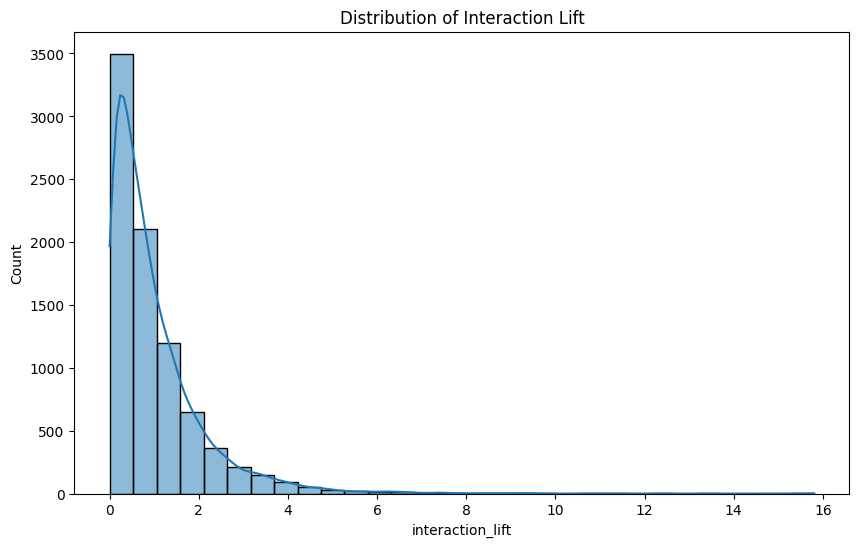

In [104]:
plt.figure(figsize=(10, 6))

# 绘制 interaction_lift 的分布图 (直方图 + 密度曲线)
sns.histplot(agg['interaction_lift'], kde=True, bins=30)

# 添加标题
plt.title('Distribution of Interaction Lift')
plt.show()

In [ ]:
pd.Series(all_pairs).to_csv('all_category_pairs.csv', index=False)
pd.Series(stable_high_synergy_pairs).to_csv('stable_high_synergy_pairs.csv', index=False)